# Load Data
* Fetch data from csv file and put it into a Pandas DataFrame.

In [44]:
import pandas as pd

covid_data = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')

# Data Preparation
* Since we want to predict cases for the US, we will extract the row containing US confirmed covid cases.

In [45]:
us_covid_data = covid_data.loc[covid_data['Country/Region'] == 'US']

us_covid_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21
249,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,27899755,28006110,28077620,28134115,28190159,28261595,28336097,28413388,28486394,28554465


### Preprocess Data
* We can drop the columns for 'Province/State', 'Country/Region', 'Lat', and 'Long' since we know the data is only for the US and these columns are not needed for prediction.

In [46]:
us_covid_data = us_covid_data.drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long'])

* Since the number of Corona cases gets rather large over time our model's calculations during training may be very slow. We can fix this by using sklearn's MinMaxScaler to rescale our data.

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(us_covid_data.values.T)
us_covid_data = scaler.transform(us_covid_data.values.T)

### Split Into X and y
* We will set up our X and y in such a way that X[n] will contain the cases for a certain amount of previous days (time_steps), and y[n] will then contain the reading for the next day.
* This way our model will be trained to predict the number of cases on a certain day based on the trend in the number of cases within the previous time_steps number of days.
* After some testing, I have found that using the data from the previous 30 days allowed our model to make fairly accurate predictions on the 31st day.

In [48]:
import numpy as np

X, y = [], []
time_steps = 30

for i in range(len(us_covid_data) - time_steps):
    x = us_covid_data[i:(i+time_steps), 0]
    X.append(x)
    y.append(us_covid_data[i+time_steps, 0])

X = np.array(X)
y = np.array(y)

# Data Partitioning
* Must keep the data set in order since we are looking at a chronological timeline of Corona cases, so we can just take the first 80% of the data as our training, and our testing will be the remaining 20%.
* Also need to reshape the X[n] partitions so our model can process them properly.

In [49]:
split = int(len(X) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model Architecture
* We create our model using a reccurent neural network architecture.
* Model consists of an input layer, followed by three LSTM layers which utilize dropout to prevent our model from overfitting.
* Output is a Dense layer with a single neuron using ReLU activation function since we are predicting the number of Corona cases, so our output will be a positive number (0, $\infty$).

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(48))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))


model.compile(loss = 'mean_squared_error',
              optimizer = RMSprop(),
              metrics = ['mean_squared_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 48)             15168     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 48)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 48)             18624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 48)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dropout_11 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# Train the Model
* Now we can train our model using 20% of the training data as our validation set.
* Model will utilize the ReduceLROnPlateau to lower our learning rate any time our validation MSE plateaus for three epochs for best accuracy.

In [51]:
from keras.callbacks import ReduceLROnPlateau

batchsize = 100
epochs =  100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)

history = model.fit(X_train,
                    y_train,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
3/3 [==============================] - 7s 637ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.1351 - val_mean_squared_error: 0.1351
Epoch 2/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.1165 - val_mean_squared_error: 0.1165
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0979 - val_mean_squared_error: 0.0979
Epoch 4/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0596 - val_mean_squared_error: 0.0596
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 7/100
3/3 [======================

3/3 [==============================] - 0s 35ms/step - loss: 8.6891e-04 - mean_squared_error: 8.6891e-04 - val_loss: 8.5231e-04 - val_mean_squared_error: 8.5231e-04
Epoch 46/100
3/3 [==============================] - 0s 36ms/step - loss: 7.9959e-04 - mean_squared_error: 7.9959e-04 - val_loss: 8.4936e-04 - val_mean_squared_error: 8.4936e-04

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 47/100
3/3 [==============================] - 0s 35ms/step - loss: 8.8351e-04 - mean_squared_error: 8.8351e-04 - val_loss: 8.4585e-04 - val_mean_squared_error: 8.4585e-04
Epoch 48/100
3/3 [==============================] - 0s 34ms/step - loss: 8.0168e-04 - mean_squared_error: 8.0168e-04 - val_loss: 8.4556e-04 - val_mean_squared_error: 8.4556e-04
Epoch 49/100
3/3 [==============================] - 0s 37ms/step - loss: 8.5777e-04 - mean_squared_error: 8.5777e-04 - val_loss: 8.4663e-04 - val_mean_squared_error: 8.4663e-04

Epoch 00049: ReduceLROnPlateau reducing learni

3/3 [==============================] - 0s 36ms/step - loss: 7.8121e-04 - mean_squared_error: 7.8121e-04 - val_loss: 8.4045e-04 - val_mean_squared_error: 8.4045e-04

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.
Epoch 86/100
3/3 [==============================] - 0s 35ms/step - loss: 8.3377e-04 - mean_squared_error: 8.3377e-04 - val_loss: 8.4045e-04 - val_mean_squared_error: 8.4045e-04
Epoch 87/100
3/3 [==============================] - 0s 36ms/step - loss: 7.7731e-04 - mean_squared_error: 7.7731e-04 - val_loss: 8.4045e-04 - val_mean_squared_error: 8.4045e-04
Epoch 88/100
3/3 [==============================] - 0s 36ms/step - loss: 8.7662e-04 - mean_squared_error: 8.7662e-04 - val_loss: 8.4045e-04 - val_mean_squared_error: 8.4045e-04

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 89/100
3/3 [==============================] - 0s 35ms/step - loss: 7.7837e-04 - mean_squared_error: 7.7837e-04 - val_loss: 8.4045e-04 - val_mean_squared

* Plot the model's loss and MSE values throughout training.

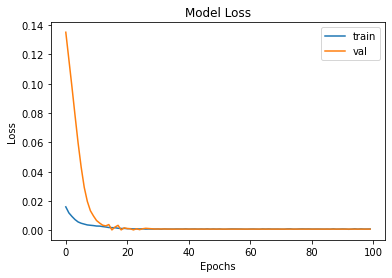

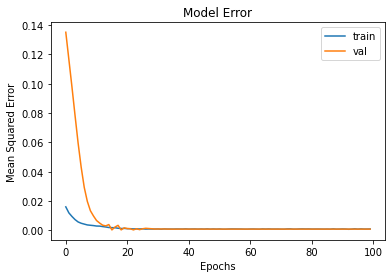

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# Plot Model Predictions
* In order to see the accuracy of our model, we first use it to predict the output of our X_test data.
* We then rescale our prediction and y_test data back to the original bounds of the data set in order to accurately plot their values.
* Finally, we can plot the actual Covid cases compared to our predicted Covid cases to see the overall accuracy of our model.

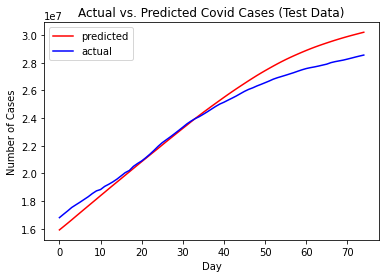

In [53]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color='red')
plt.plot(y_test, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])